### Comparing kernel matrices with different approaches

In [78]:
using Flux,LinearAlgebra,CairoMakie,Random,ProgressMeter
Random.seed!(123)

TaskLocalRNG()

In [79]:
include("DenseNTK.jl")
include("normNTK.jl")

kernel (generic function with 2 methods)

We start by making a model using DenseNTK that works like Dense in Flux but is more general in a sense of calculating the kernel


In [80]:
Nh = 1000
model = Chain(DenseNTK(1=>Nh,tanh),DenseNTK(Nh=>1))
θ = Flux.params(model)
Nx = 40
xa = -1.0
xb = 1.0
xR = range(xa,stop=xb,length=Nx) 
x = hcat(xR...)


1×40 Matrix{Float64}:
 -1.0  -0.948718  -0.897436  -0.846154  …  0.846154  0.897436  0.948718  1.0

In [81]:

K_i = zeros(Float64,3*Nh+1,Nx)
@showprogress for i = 1:Nx
    ∇_SIE = Flux.gradient(()-> model([x[i]])[1],θ)
    K_i[1:Nh,i] = ∇_SIE[θ[1]][:]
    K_i[Nh+1:2*Nh,i] = ∇_SIE[θ[2]][:]
    K_i[2*Nh+1:3*Nh,i] = ∇_SIE[θ[3]][:]
    K_i[3*Nh+1:3*Nh+1,i] = ∇_SIE[θ[4]][:] 
end

Kernel_SIE = K_i[1:3*Nh,:]'*K_i[1:3*Nh,:]
# eigen(Kernel_SIE).values

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


40×40 Matrix{Float64}:
  1.29633      1.28053      1.26266     …  -0.0249435    -0.050961
  1.28053      1.26668      1.25082         0.000324255  -0.0253381
  1.26266      1.25082      1.23702         0.0266587     0.00136198
  1.24266      1.23285      1.22116         0.0541019     0.029182
  1.22047      1.2127       1.20315         0.0826918     0.0581611
  1.19605      1.19032      1.18294     …   0.11246       0.088332
  1.1694       1.1657       1.16047         0.143429      0.119718
  1.14053      1.13882      1.13573         0.175607      0.152329
  1.10952      1.10974      1.10874         0.208986      0.186158
  1.07645      1.07853      1.07955         0.243537      0.221179
  ⋮                                     ⋱                
  0.188071     0.210524     0.233914        1.09003       1.09111
  0.154161     0.177057     0.200916        1.11909       1.12211
  0.121444     0.144769     0.169079        1.14623       1.15123
  0.0899053    0.113643     0.138388        1.1

In [82]:
K = kernel(model,x,true)


Computing kernel: 100%|██████████████████████████████████████████████████| Time: 0:00:02


40×40 Matrix{Float64}:
  1.29633      1.28053      1.26266     …  -0.0249435    -0.050961
  1.28053      1.26668      1.25082         0.000324255  -0.0253381
  1.26266      1.25082      1.23702         0.0266587     0.00136198
  1.24266      1.23285      1.22116         0.0541019     0.029182
  1.22047      1.2127       1.20315         0.0826918     0.0581611
  1.19605      1.19032      1.18294     …   0.11246       0.088332
  1.1694       1.1657       1.16047         0.143429      0.119718
  1.14053      1.13882      1.13573         0.175607      0.152329
  1.10952      1.10974      1.10874         0.208986      0.186158
  1.07645      1.07853      1.07955         0.243537      0.221179
  ⋮                                     ⋱                
  0.188071     0.210524     0.233914        1.09003       1.09111
  0.154161     0.177057     0.200916        1.11909       1.12211
  0.121444     0.144769     0.169079        1.14623       1.15123
  0.0899053    0.113643     0.138388        1.1

In [83]:
round.(K[:,:],digits=13)==round.(Kernel_SIE[:,:],digits=13)

true

In [84]:
# eigen(Kernel_SIE).values
λ = eigen(K).values
λ = abs.(λ)
λ = sort!(λ)



for i = 1:Nx
    if λ[i] == 0
        λ[i] = 10^(-19)
    end
end

λ

40-element Vector{Float64}:
  1.1307827102663627e-16
  2.0461420475818398e-16
  3.0902543400833045e-16
  3.1265920407849054e-16
  3.349110509655527e-16
  5.499599676124807e-16
  5.939767462853483e-16
  6.661338147750939e-16
  7.025467526795362e-16
  7.172425320060642e-16
  ⋮
  0.00014813742388932328
  0.0006418983135644582
  0.0027553675971726246
  0.007809401696447601
  0.03270574491567196
  0.18436189343690296
  0.8491173615860088
 11.382248040662542
 29.355268171216466

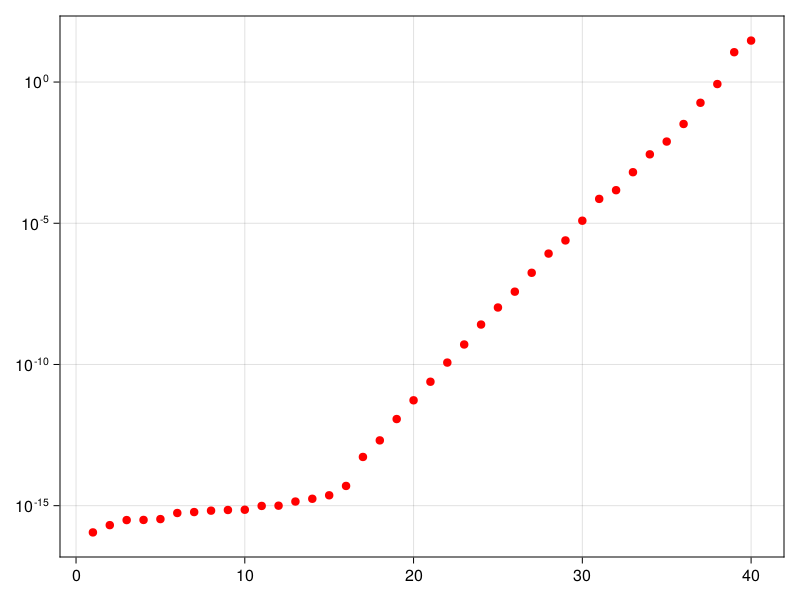

In [85]:
fig = Figure()
ax1 = Axis(fig[1,1],yscale=log10)
s1 = CairoMakie.scatter!(ax1,λ[:],color=:red)
fig


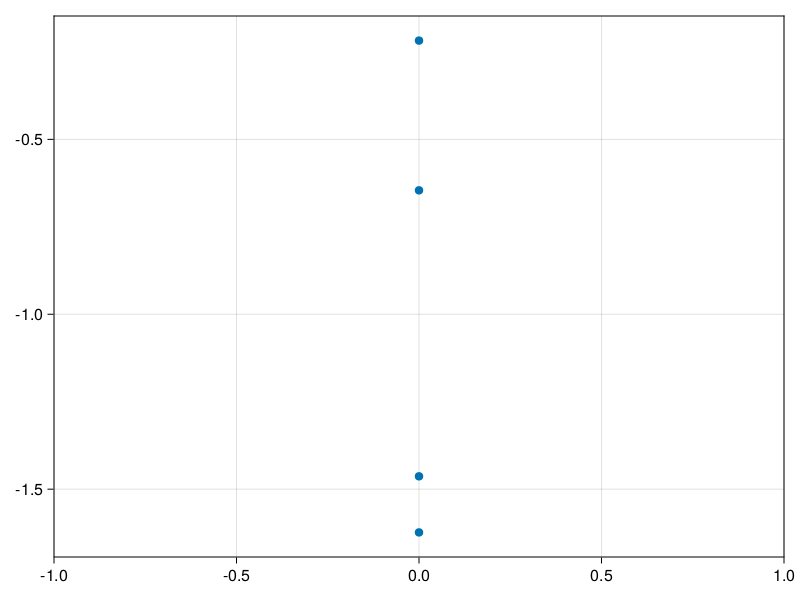

In [86]:
t = [0]
fig = Figure()
ax1 = Axis(fig[1,1])
CairoMakie.scatter!(ax1,t,θ[1][1:4])
fig



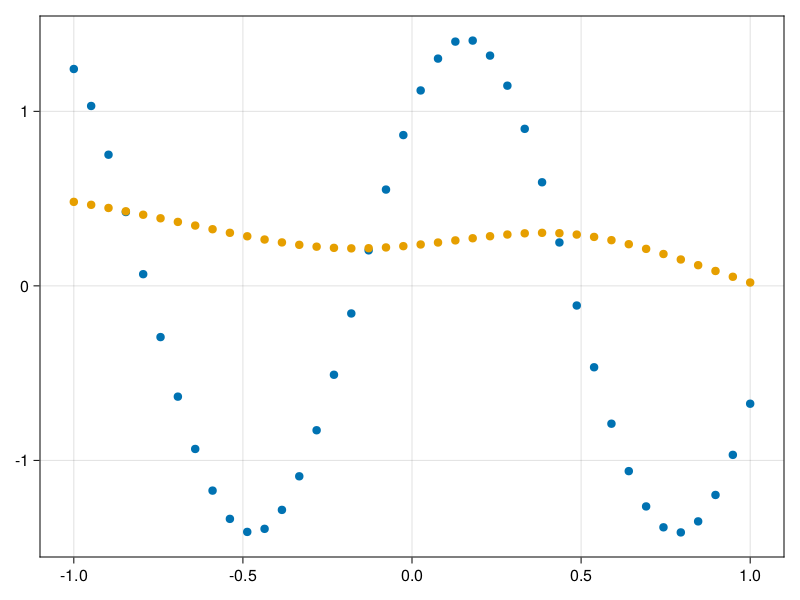

In [87]:
x_train = x
f = x->sin(5*x)+cos(5*x)
y_train = map(f,x_train)
y_hat = model(x_train)
fig = Figure()
ax1 = Axis(fig[1,1])
CairoMakie.scatter!(ax1,x_train[:],y_train[:])
CairoMakie.scatter!(ax1,x_train[:],y_hat[:])
fig


In [88]:
y_train_hat = model(x_train)
Loss(model,x,y) = Flux.mse(y,model(x))
loss = Loss(model,x_train,y_train)
train_data = [(x_train,y_train)]



1-element Vector{Tuple{Matrix{Float64}, Matrix{Float64}}}:
 ([-1.0 -0.9487179487179487 … 0.9487179487179487 1.0], [1.2425864601263648 1.0307089968649938 … -0.9683175944810455 -0.6752620891999122])

In [89]:

train_data = [(x_train,y_train)]
η = 1/λ[end]
Nepoch = 50000
L = []


layer = 3
θ_stop = 6
θ_s = zeros(Nepoch,θ_stop)
@showprogress for epoch = 1:Nepoch
    Flux.train!(Loss,model,train_data,Descent(η))
    for i = 1:θ_stop
        θ_s[epoch,i] = Flux.params(model)[layer][i]
    end
        
    push!(L,Loss(model,x_train,y_train))
end



Progress: 100%|█████████████████████████████████████████| Time: 0:01:01


In [90]:
L = hcat(L...)

1×50000 Matrix{Float64}:
 1.05116  1.01704  0.990305  0.969307  …  0.0134927  0.0134924  0.013492

In [97]:
t = 1:Nepoch
dt = hcat(t...)



1-element Vector{Float32}:
 1.1556278

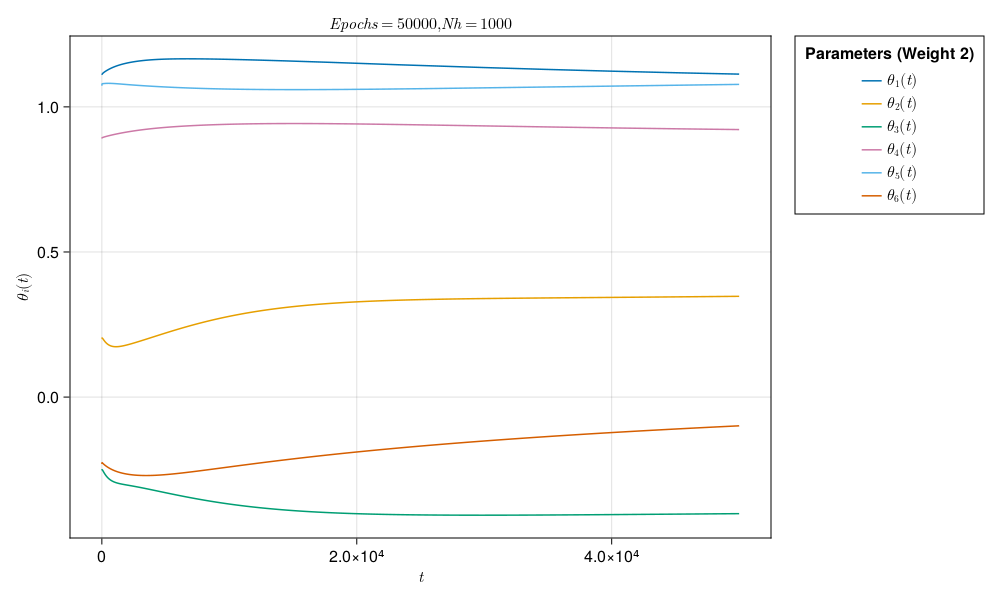

In [96]:
fig = Figure(resolution=(1000, 600))

# Creating a grid layout for the figure: 1 row, 2 columns
# The first column for the plot, the second for the legend
grid = fig[1, 1] = GridLayout()
ax1 = Axis(grid[1, 1], title=L"Epochs = %$Nepoch, Nh = %$Nh", xlabel=L"t", ylabel=L"θ_i(t)")

# Plotting data
for i = 1:θ_stop
    lines!(ax1, dt[:], θ_s[:,i], label=L"θ_{%$i}(t)")
end

# Adjusting the layout to leave space for the legend outside the plot
grid[1, 2] = Legend(fig, ax1, "Parameters (Weight 2)", valign=:top, orientation=:vertical)


fig

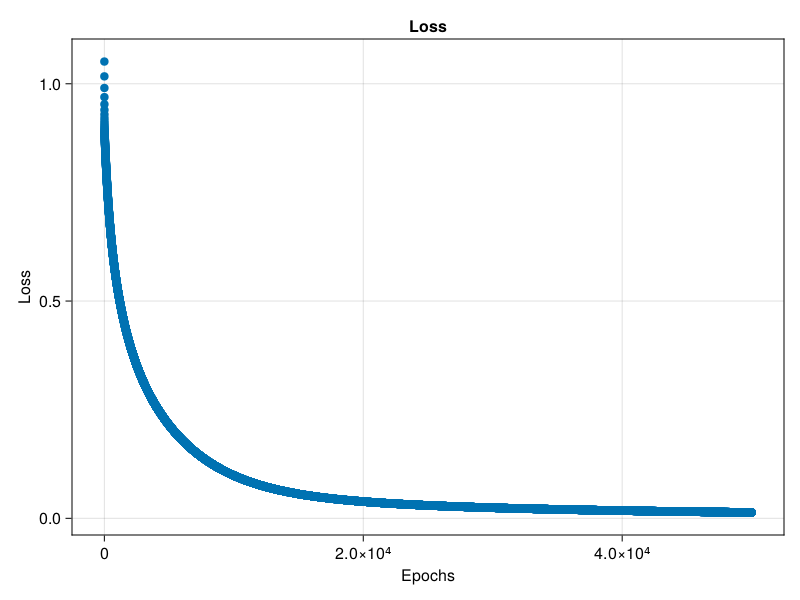

In [93]:
fig = Figure()
ax1 = Axis(fig[1,1],title = "Loss",xlabel="Epochs",ylabel="Loss")
CairoMakie.scatter!(ax1,dt[:],L[:])


fig


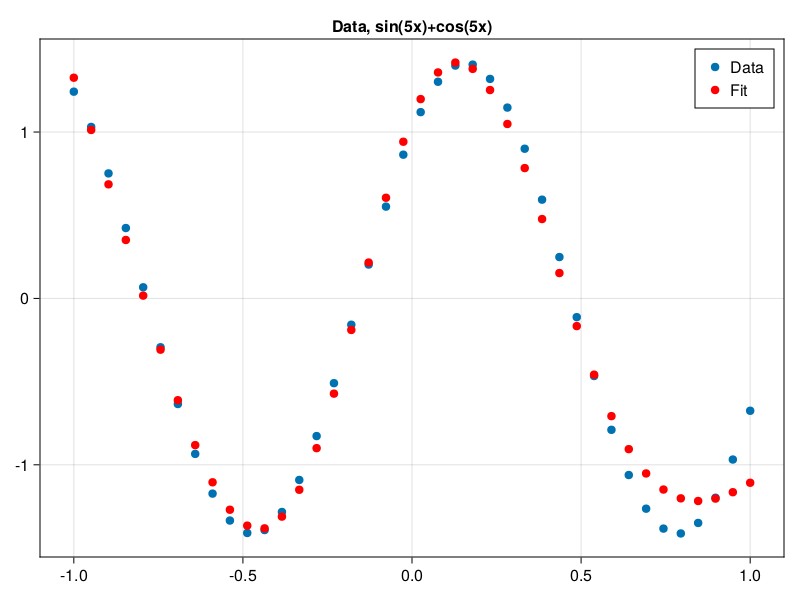

In [94]:
fig = Figure()
ax1 = Axis(fig[1,1],title = "Data, sin(5x)+cos(5x)")
CairoMakie.scatter!(ax1,x_train[:],y_train[:],label="Data")
CairoMakie.scatter!(ax1,x_train[:],model(x_train)[:],color=:red,label="Fit")
axislegend(ax1,position=:rt)
fig


### Parameters 

#### Run1 500000 Epochs RELU
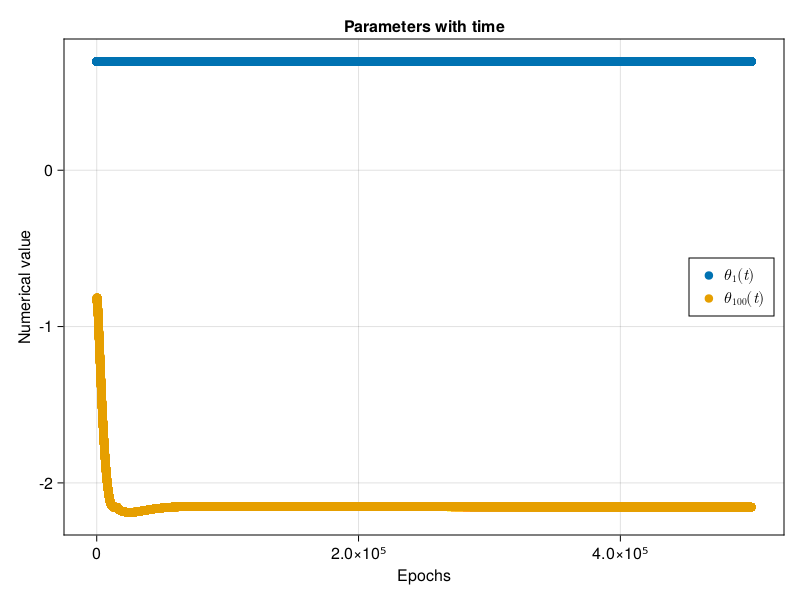

#### Run2 500000 Epochs RELU
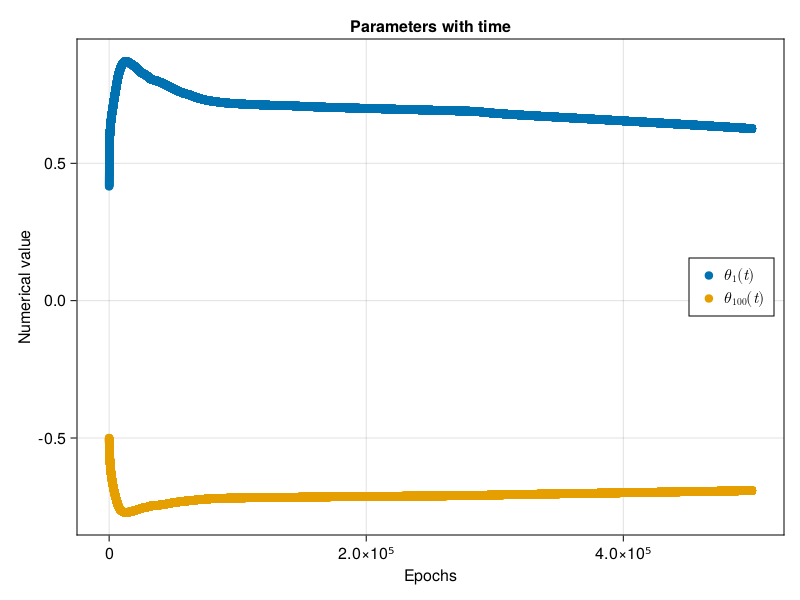

#### Run3 50000 Epochs RELU
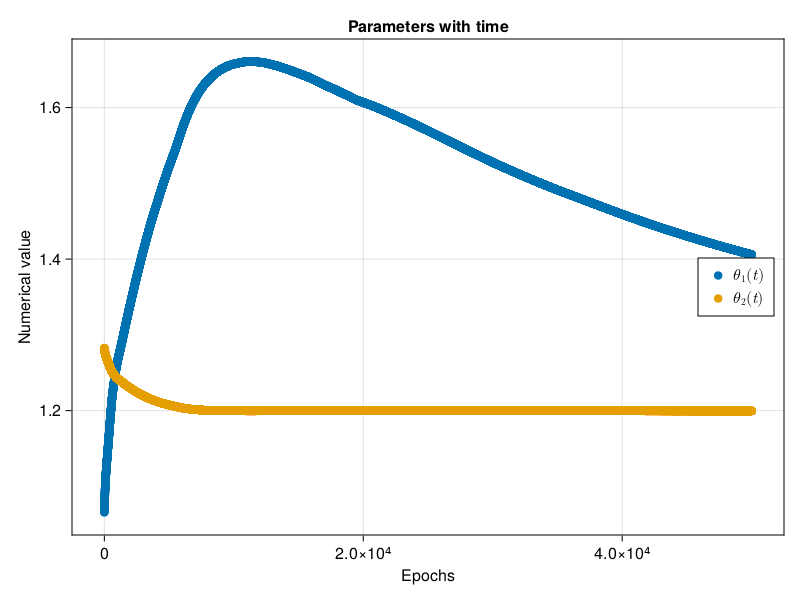

#### Run4 50000 Epochs RELU
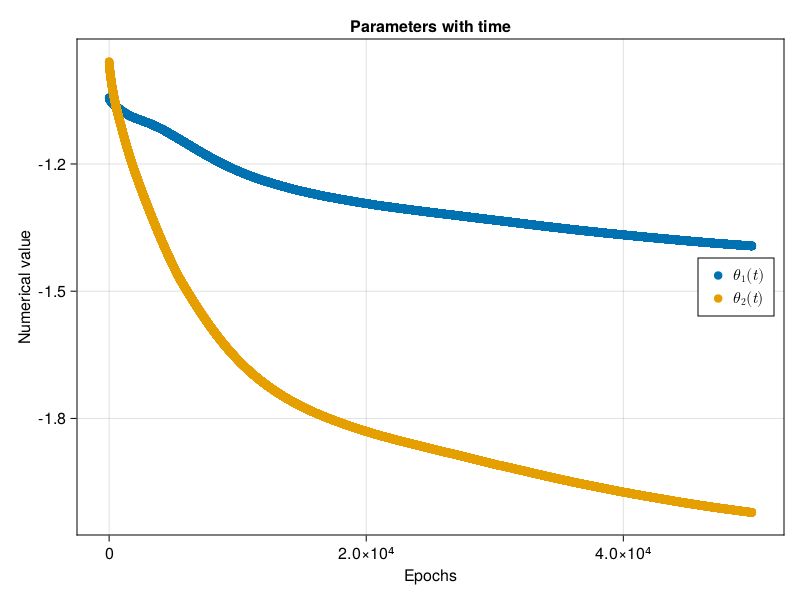


#### Run5 50000 Epochs tanh
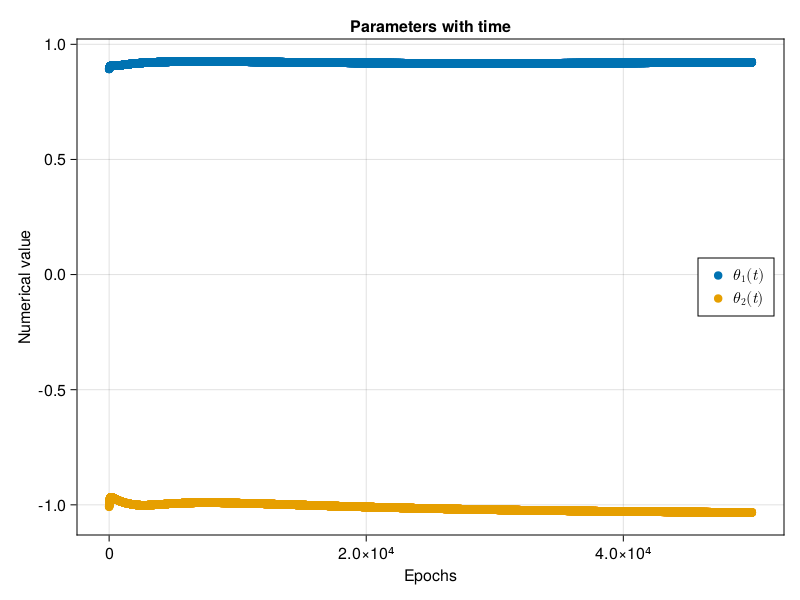

#### Run6 50000 Eochs tanh
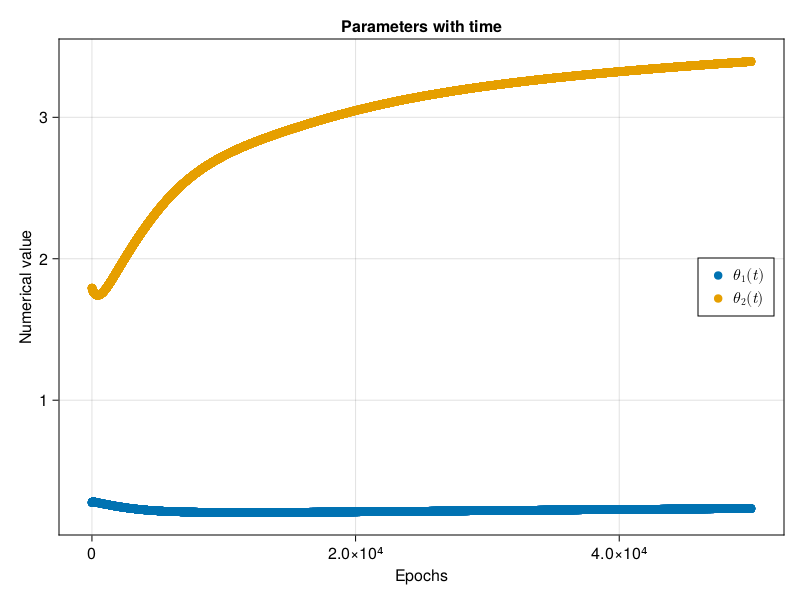